# EXPLORATORY DATA ANALYSIS AND MODELLING
### Purpose 
1.To determine the relationship between the dependent and independent variables.

2.To select relevant features for modelling.

3.To build a logistic regression model.

4.To build a Decision tree classifier model.

In [7]:
#importing the relevant libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
from pandasql import sqldf
from tabulate import tabulate
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings("ignore")
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc



In [8]:
#loading the data
df=pd.read_csv("EDA_data.csv")

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61459 entries, 0 to 61458
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         61459 non-null  int64 
 1   Subject Age Group  61459 non-null  object
 2   GO / SC Num        61459 non-null  int64 
 3   Stop Resolution    61459 non-null  object
 4   Weapon Type        61459 non-null  object
 5   Officer YOB        61459 non-null  int64 
 6   Initial Call Type  61459 non-null  object
 7   Final Call Type    61459 non-null  object
 8   Call Type          61459 non-null  object
 9   Officer Squad      61459 non-null  object
 10  Arrest Flag        61459 non-null  int64 
 11  Frisk Flag         61459 non-null  int64 
 12  Precinct           61459 non-null  object
 13  Sector             61459 non-null  object
 14  Beat               61459 non-null  object
 15  reported_Year      61459 non-null  int64 
 16  reported_Month     61459 non-null  int64

In [10]:
#dropping the collumn Unnamed: 0
df=df.drop(columns=["Unnamed: 0"])

### 1.What is the distribution of terry stops over the years

In [11]:
#Create a lambda function to pass locals or globals to pandasql
pysqldf = lambda q:sqldf(q, globals())

In [12]:
q1="""
SELECT reported_Year,COUNT("Arrest Flag")as "terry_stops"
FROM df
GROUP BY reported_Year
"""
year_vs_arrest=pysqldf(q1)
year_vs_arrest

,reported_Year,terry_stops
0,2015,6746
1,2016,7704
2,2017,7469
3,2018,8851
4,2019,8190
5,2020,6128
6,2021,4228
7,2022,4626
8,2023,4049
9,2024,3468


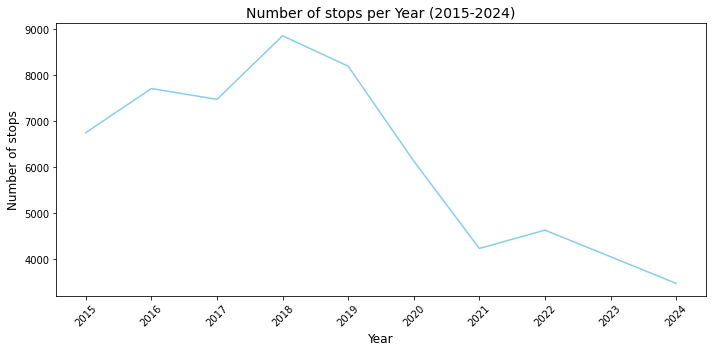

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(year_vs_arrest["reported_Year"], year_vs_arrest["terry_stops"], color='skyblue')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of stops', fontsize=12)
plt.title('Number of stops per Year (2015-2024)', fontsize=14)
plt.xticks(year_vs_arrest["reported_Year"], rotation=45)
plt.tight_layout()
plt.show()


### Observation
The data shows that the number of terry stops steadily increased from the year 2015 with the peak number of terry stops being in the year 2018.There after,the number of terry stops decreased with the record lowest being in 2024 with only 3468 terry stops.This can be attributed to the rapid growth in promoting stationary ALPR cameras since 2019 and by  April 2022, 1500 cities across the United States had implemented Flock cameras<sup>1</sup>.These cameras are used to run plates and if the driver's licence is found to be expired,a terry stop is initiated.This has probably led to a decrease in the terry stops.

### 2. How many terry stops led to an arrest?

In [14]:
q2="""
SELECT "Arrest Flag" ,COUNT("Arrest Flag") AS "outcome"
FROM df
GROUP BY "Arrest Flag"
"""
arrest=pysqldf(q2)
arrest

,Arrest Flag,outcome
0,0,54699
1,1,6760


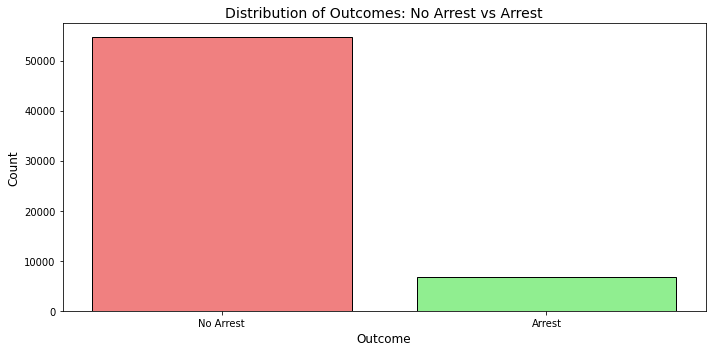

In [15]:
plt.figure(figsize=(10, 5))
outcomes = ["No Arrest", "Arrest"]# Replacing arrest["outcome"] and arrest["Arrest Flag"] with the correct mappings
counts = [54699, 6760]
plt.bar(outcomes, counts, color=['lightcoral', 'lightgreen'], edgecolor='black')
plt.xlabel('Outcome', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Outcomes: No Arrest vs Arrest', fontsize=14)
plt.tight_layout()  
plt.show()

### Observation 

Between 2015 and 2024, a total of 6,760 arrests were recorded, accounting for 10% of all observations. Over a period of approximately 10 years, 61,459 Terry stops were conducted, but only 6,160 resulted in arrests.

### 3.What arrests were made based on the call type?

In [16]:
q3 = """
SELECT "Call Type", COUNT(*) AS "Arrest Count"
FROM df
WHERE "Arrest Flag" = 1
GROUP BY "Call Type"
ORDER BY "Arrest Count" DESC
"""
arrest_call = pysqldf(q3)
print(arrest_call)


                       Call Type  Arrest Count
0                            911          4506
1                         ONVIEW          1421
2       TELEPHONE OTHER, NOT 911           502
3              Call Type UNKNOWN           234
4  ALARM CALL (NOT POLICE ALARM)            88
5                    OTHER CALLS             9


<h3>Observation</h3>
911 calls topped the list with 4,506 arrests followed by onview at 1,421 ,telephone other(not911) at 502,unknown at 234 and alarm call  and other types of calls cumulated to 97. 

### 4.What is the distribution of arrests based on the the subjects age?

In [17]:
q4 = """
SELECT "Subject Age Group", CAST(COUNT("Arrest Flag") AS INTEGER) AS "Arrest Count"
FROM df
WHERE "Arrest Flag" = 1
GROUP BY "Subject Age Group"
ORDER BY "Subject Age Group" 
"""
arrest_age=pysqldf(q4)
total_arrests = arrest_age["Arrest Count"].sum()
# Adding a new column for the percentage
arrest_age["Arrest Percentage"] = (arrest_age["Arrest Count"] / total_arrests) * 100
print(arrest_age)


  Subject Age Group  Arrest Count  Arrest Percentage
0            1 - 17           137           2.026627
1           18 - 25          1108          16.390533
2           26 - 35          2443          36.139053
3           36 - 45          1797          26.582840
4           46 - 55           857          12.677515
5      56 and Above           377           5.576923
6       Age Unknown            41           0.606509


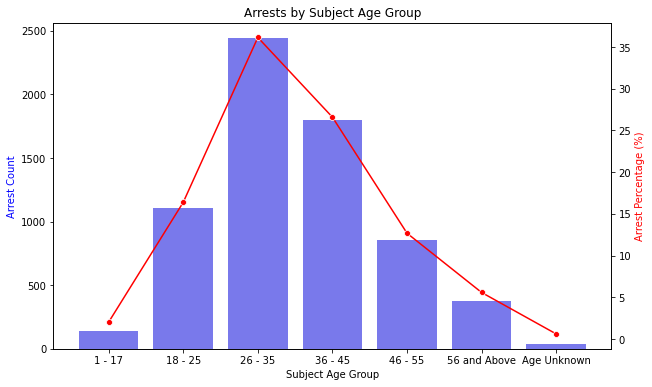

In [18]:
fig, ax1 = plt.subplots(figsize=(10, 6))

sns.barplot(x="Subject Age Group", y="Arrest Count", data=arrest_age, ax=ax1, color="b", alpha=0.6)
ax2 = ax1.twinx()
sns.lineplot(x="Subject Age Group", y="Arrest Percentage", data=arrest_age, ax=ax2, color="r", marker="o")
ax1.set_xlabel("Subject Age Group")
ax1.set_ylabel("Arrest Count", color="b")
ax2.set_ylabel("Arrest Percentage (%)", color="r")
plt.title("Arrests by Subject Age Group")
plt.show()


<h3>Observation</h3>
Ages in the range of 26-35 contibuted 36% of the arrests made followed by ages between 36 and 45 which contributed about 27%.Age group 1-17 accounted for the least arrests followed by ages 46-55 at 5.5%.The adult age in USA is 18 years and the individuals in the subject groups were probably given a warning as they are still under parental protection and care.Individuals aged 56 and above may be perceived not to be a threat. 

In [19]:
q5 = """
SELECT "Precinct",COUNT("Precinct"),"Beat"
FROM df
WHERE "Arrest Flag" = 1
GROUP BY "Precinct"
"""
precinct_beat = pysqldf(q5)
precinct_beat

,Precinct,"COUNT(""Precinct"")",Beat
0,East,1021,G3
1,FK ERROR,4,99
2,North,1137,N2
3,OOJ,8,OOJ
4,South,967,R2
5,Southwest,658,F1
6,West,2606,M3
7,precinct Unknown,359,Beat UNKNOWN


West M3 beat accounted for the most of arrests with 2,606 arrests made.this was followed by the north precinct which had 1,137 arrests.  

### 5.What is the relationship between officer experience and the arrest flag


In [20]:
q6 = """
SELECT "Officer YOB", 
       CAST(COUNT("Arrest Flag") AS INTEGER) AS arrest_count,ABS("Officer YOB"-2024)AS "Officer probable age"
FROM df
WHERE "Arrest Flag" == 1 AND "Officer probable age"<=53
GROUP BY "Officer YOB"
ORDER BY arrest_count DESC
LIMIT 10
"""
officer_experience = pysqldf(q6)
officer_experience


,Officer YOB,arrest_count,Officer probable age
0,1995,565,29
1,1989,479,35
2,1993,478,31
3,1992,455,32
4,1991,455,33
5,1987,451,37
6,1986,426,38
7,1990,416,34
8,1994,319,30
9,1988,277,36


For the above analysis we assume that the retirement age for an officer in seattle is 53 years, therefore limiting our analysis to only officers who are below the age of 53.Most arrests were made by officers between the ages of 29 and 38.Assuming an officer joins the force at the age of 18 then we can conclude that officers with more than 10 years of experience made correct judgements based on terry traffic stops.

### 6.Officers who initiated a terry stop but never made an arrest

In [21]:
q7 = """
SELECT "Officer YOB", 
       CAST(COUNT("Arrest Flag") AS INTEGER) AS arrest_count,ABS("Officer YOB"-2024)AS "Officer probable age"
FROM df
WHERE "Arrest Flag" ==0 AND "Officer probable age"<=53
GROUP BY "Officer YOB"
ORDER BY arrest_count DESC
LIMIT 10
"""
officer_experience = pysqldf(q7)
officer_experience


,Officer YOB,arrest_count,Officer probable age
0,1986,3596,38
1,1987,3353,37
2,1991,2971,33
3,1984,2949,40
4,1992,2892,32
5,1990,2733,34
6,1985,2679,39
7,1989,2558,35
8,1988,2338,36
9,1982,1921,42


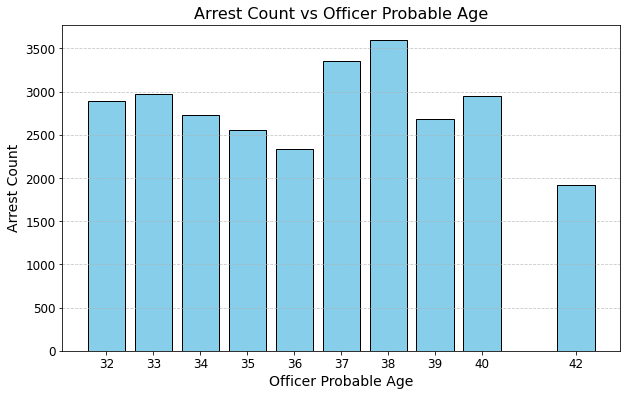

In [22]:
plt.figure(figsize=(10, 6))
plt.bar(officer_experience["Officer probable age"], officer_experience["arrest_count"], color='skyblue', edgecolor='black')

# Customize the plot
plt.title("Arrest Count vs Officer Probable Age", fontsize=16)
plt.xlabel("Officer Probable Age", fontsize=14)
plt.ylabel("Arrest Count", fontsize=14)
plt.xticks(officer_experience["Officer probable age"],fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)



### Observation:
Officers between the ages of 32 and 42 initiated the most terry stops but did not make an arrest.This leads to the question is there a relationship between officer age and terry stops initiated?

### correlation between officer age and terry stops initiated

In [23]:
correlation=df["Officer YOB"].corr(df["Arrest Flag"])
correlation

0.13973448176624767

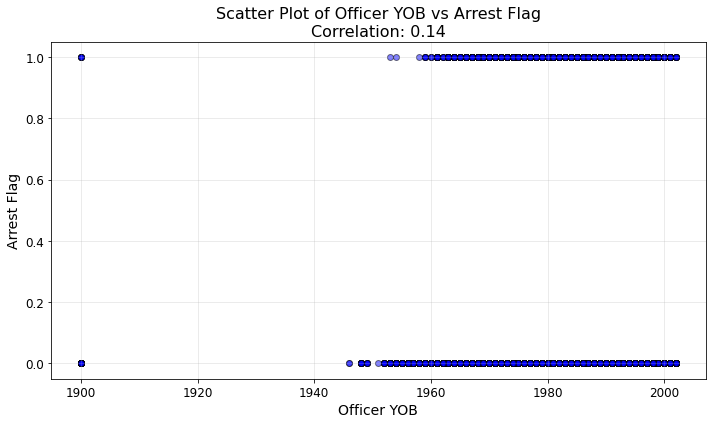

0.13973448176624767

In [24]:
# Creating a scatter plot to visualize the correlation
plt.figure(figsize=(10, 6))
plt.scatter(df["Officer YOB"], df["Arrest Flag"], color='blue', alpha=0.5, edgecolor='black')
plt.title(f"Scatter Plot of Officer YOB vs Arrest Flag\nCorrelation: {correlation:.2f}", fontsize=16)
plt.xlabel("Officer YOB", fontsize=14)
plt.ylabel("Arrest Flag", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
correlation


A correlation of 0.14 indicates a very weak correlation.This indicates that there is no linear relationship between the officer age and terry stops.We can conclude that terry stops were random and did not depend on an officer's age.

### 7 What is the relationship between date,day of the week and arrest flag

In [25]:
#Day of the week:monday:0,tuesday:1,wednesday:2,thursday:3,friday:4,saturday:5,sunday:6
q8="""
SELECT "reported_Month",day_of_week,COUNT("Arrest Flag") AS Arrests
FROM df
WHERE "Arrest Flag"==1
GROUP BY "reported_Month"
ORDER BY Arrests desc
"""
arrest_time=pysqldf(q8)
print(tabulate(arrest_time, headers="keys", tablefmt="fancy_grid"))

╒════╤══════════════════╤═══════════════╤═══════════╕
│    │   reported_Month │   day_of_week │   Arrests │
╞════╪══════════════════╪═══════════════╪═══════════╡
│  0 │                5 │             3 │       670 │
├────┼──────────────────┼───────────────┼───────────┤
│  1 │                7 │             6 │       631 │
├────┼──────────────────┼───────────────┼───────────┤
│  2 │               10 │             4 │       625 │
├────┼──────────────────┼───────────────┼───────────┤
│  3 │               11 │             3 │       596 │
├────┼──────────────────┼───────────────┼───────────┤
│  4 │                9 │             5 │       585 │
├────┼──────────────────┼───────────────┼───────────┤
│  5 │                6 │             6 │       566 │
├────┼──────────────────┼───────────────┼───────────┤
│  6 │                8 │             1 │       539 │
├────┼──────────────────┼───────────────┼───────────┤
│  7 │                1 │             6 │       535 │
├────┼──────────────────┼───

<h3>Observation</h3>
The terry stops that led to arrest occured on friday through to
saturday.May recorded the highest number of arrests were with 670 arrests.August,September,October November also registered high numbers of arrests .The least arrests were made in the months of December, January,February,March and April.

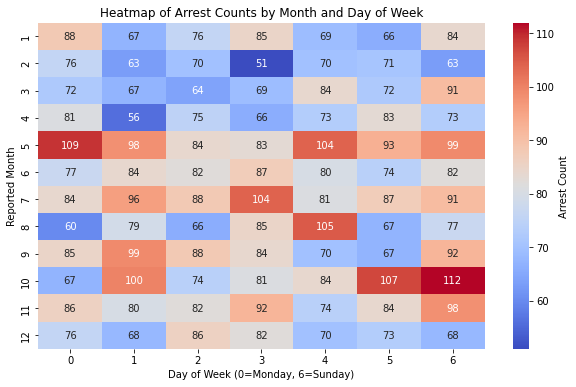

In [26]:
# Group by month and day of week, then pivot for heatmap data
heatmap_data =df.pivot_table(
    values='Arrest Flag',
    index='reported_Month',
    columns='day_of_week',
    aggfunc='sum',
    fill_value=0
)
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="coolwarm", cbar_kws={'label': 'Arrest Count'})
plt.title("Heatmap of Arrest Counts by Month and Day of Week")
plt.xlabel("Day of Week (0=Monday, 6=Sunday)")
plt.ylabel("Reported Month")
plt.show()


The heatmap indicates that Terry stops on weekends in October are more likely to result in arrests. Having identified the months and days of the week when arrests are most probable following a Terry stop, let’s now explore whether being found with a weapon at specific times of the day further exacerbates the situation.

### 8 Does being found with a weapon or not likely to lead to an arrest?

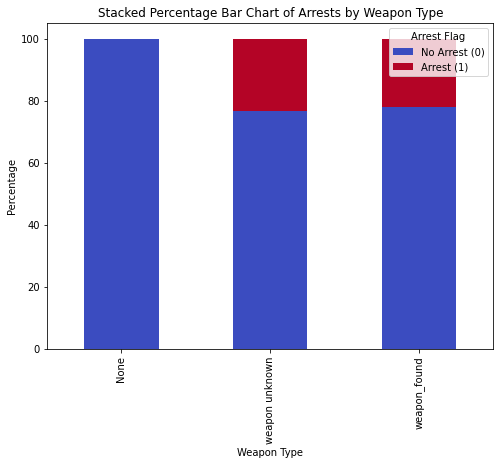

Arrest Flag,0,1
Weapon Type,,
None,99.978280,0.021720
weapon unknown,76.746665,23.253335
weapon_found,77.880421,22.119579


In [27]:
counts = df.groupby(["Weapon Type", "Arrest Flag"]).size().unstack(fill_value=0)
# Normalize counts to percentages
percentages = counts.div(counts.sum(axis=1), axis=0) * 100
percentages.plot(kind="bar", stacked=True, figsize=(8, 6), colormap="coolwarm")
plt.title("Stacked Percentage Bar Chart of Arrests by Weapon Type")
plt.xlabel("Weapon Type")
plt.ylabel("Percentage")
plt.legend(["No Arrest (0)", "Arrest (1)"], title="Arrest Flag")
plt.show()
percentages

When a suspect is not found with a weapon, they are released 99.97% of the time. Cases where the weapon type was unknown accounted for approximately 23% of arrests, while weapons being found contributed to 22% of arrests. Notably, only 0.022% of individuals not found with a weapon were arrested.

### 9 Distribution of arrests based on the time 

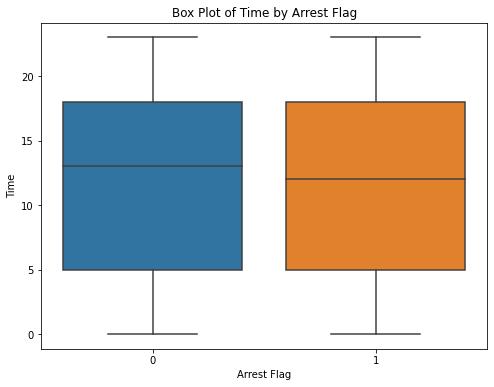

In [28]:
# Box plot to compare the distribution of Time for Arrest Flag
plt.figure(figsize=(8, 6))
sns.boxplot(x='Arrest Flag', y='Time', data=df)
plt.title("Box Plot of Time by Arrest Flag")
plt.xlabel("Arrest Flag")
plt.ylabel("Time")
plt.show()


There seems to be no varience in the median therefore time does not influence arrest flag

### CONCLUSION

It is observed that over the years,the number of terry stops have gradually decreased with the lowest being registered in 2024.Time of the day and officer's age did not seem to influence the arrests much.Subject age,month,day of the week,call type,location(sector and precinct) and whether a subject had a weapon greatly determined if an arrest would be made or not.911 calls led to the most of arrests. 

### Recommendation
1.Build a model to predict terry stops based on the observed features.

2.Focus should be put on 911 calls.

3.Certain areas should be prioritized when handling terry stops such as those in West precinct as they saw most of the arrests.

4.The force should aim to improve their relationship with the public as most arrests were as a result of 911 calls which come from the general public.

## 2.MODELLING AND EVALUATION

AIM:To create a model that accurately(95% and above accuracy) predict the result of a terry stop.

In [29]:
mdata=df.copy()

In [30]:
mdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61459 entries, 0 to 61458
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Subject Age Group  61459 non-null  object
 1   GO / SC Num        61459 non-null  int64 
 2   Stop Resolution    61459 non-null  object
 3   Weapon Type        61459 non-null  object
 4   Officer YOB        61459 non-null  int64 
 5   Initial Call Type  61459 non-null  object
 6   Final Call Type    61459 non-null  object
 7   Call Type          61459 non-null  object
 8   Officer Squad      61459 non-null  object
 9   Arrest Flag        61459 non-null  int64 
 10  Frisk Flag         61459 non-null  int64 
 11  Precinct           61459 non-null  object
 12  Sector             61459 non-null  object
 13  Beat               61459 non-null  object
 14  reported_Year      61459 non-null  int64 
 15  reported_Month     61459 non-null  int64 
 16  day_of_week        61459 non-null  int64

In [31]:
#frequency encoding the object columns
class FrequencyEncoder:
    def __init__(self, data):
        self.data = data 

    def encode_column(self, column_name):
        frequency = self.data[column_name].value_counts()
        self.data[column_name] = self.data[column_name].map(frequency)

    def encode_columns(self, columns):
        for column in columns:
            self.encode_column(column)
    def get_data(self):
        return self.data
encoder = FrequencyEncoder(mdata)
columns_to_encode = ["Subject Age Group", "Stop Resolution", "Weapon Type", "Initial Call Type","Final Call Type","Officer Squad","Frisk Flag","Precinct","Sector","Beat","Call Type"]
encoder.encode_columns(columns_to_encode)
encoded_data = encoder.get_data()

In [32]:
mdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61459 entries, 0 to 61458
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Subject Age Group  61459 non-null  int64
 1   GO / SC Num        61459 non-null  int64
 2   Stop Resolution    61459 non-null  int64
 3   Weapon Type        61459 non-null  int64
 4   Officer YOB        61459 non-null  int64
 5   Initial Call Type  61459 non-null  int64
 6   Final Call Type    61459 non-null  int64
 7   Call Type          61459 non-null  int64
 8   Officer Squad      61459 non-null  int64
 9   Arrest Flag        61459 non-null  int64
 10  Frisk Flag         61459 non-null  int64
 11  Precinct           61459 non-null  int64
 12  Sector             61459 non-null  int64
 13  Beat               61459 non-null  int64
 14  reported_Year      61459 non-null  int64
 15  reported_Month     61459 non-null  int64
 16  day_of_week        61459 non-null  int64
 17  Time        

In [33]:
#checking for multicollinearity
data_with_constant = add_constant(mdata)

# Calculate VIF for each feature
vif = pd.DataFrame()
vif["Feature"] = data_with_constant.columns
vif["VIF"] = [
    variance_inflation_factor(data_with_constant.values, i)
    for i in range(data_with_constant.shape[1])
]

# Display VIF
print(vif)

              Feature        VIF
0               const   0.000000
1   Subject Age Group   1.006357
2         GO / SC Num   1.103506
3     Stop Resolution   1.518859
4         Weapon Type   1.356148
5         Officer YOB   1.207795
6   Initial Call Type   8.417151
7     Final Call Type   8.015802
8           Call Type   1.277958
9       Officer Squad   1.051114
10        Arrest Flag   1.248224
11         Frisk Flag   1.178598
12           Precinct   1.410396
13             Sector  16.663518
14               Beat  17.388017
15      reported_Year   0.204092
16     reported_Month   1.001086
17        day_of_week   1.001510
18               Time   1.006695


In [34]:
#dropping the initial call type 
mdata = mdata.drop(columns=["Initial Call Type","Beat","Stop Resolution","Frisk Flag"], axis=1)
mdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61459 entries, 0 to 61458
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Subject Age Group  61459 non-null  int64
 1   GO / SC Num        61459 non-null  int64
 2   Weapon Type        61459 non-null  int64
 3   Officer YOB        61459 non-null  int64
 4   Final Call Type    61459 non-null  int64
 5   Call Type          61459 non-null  int64
 6   Officer Squad      61459 non-null  int64
 7   Arrest Flag        61459 non-null  int64
 8   Precinct           61459 non-null  int64
 9   Sector             61459 non-null  int64
 10  reported_Year      61459 non-null  int64
 11  reported_Month     61459 non-null  int64
 12  day_of_week        61459 non-null  int64
 13  Time               61459 non-null  int64
dtypes: int64(14)
memory usage: 6.6 MB


In [35]:
data_with_constant = add_constant(mdata)

# Calculate VIF for each feature
vif = pd.DataFrame()
vif["Feature"] = data_with_constant.columns
vif["VIF"] = [
    variance_inflation_factor(data_with_constant.values, i)
    for i in range(data_with_constant.shape[1])
]

# Display VIF
print(vif)

              Feature       VIF
0               const  0.000000
1   Subject Age Group  1.005060
2         GO / SC Num  1.103462
3         Weapon Type  1.109463
4         Officer YOB  1.202862
5     Final Call Type  1.757506
6           Call Type  1.205134
7       Officer Squad  1.050053
8         Arrest Flag  1.097254
9            Precinct  1.060442
10             Sector  1.565644
11      reported_Year  0.203863
12     reported_Month  1.001007
13        day_of_week  1.001182
14               Time  1.005755


In [36]:
#separating the dependent variable from the rest of the dataset
y=mdata["Arrest Flag"]
X=mdata.drop(["Arrest Flag"],axis=1)

## 2.1 Building a logistic regression baseline model

Logistic regression is a classification model used to predict binary target.Logistic regression assumes linearity,independence,and is widely affected by multicollinearity.Logistic regression works best for a linear dataset.A baseline model is a simple model without any tuning.It works as a baseline for improving the model.

In [37]:
#checking for class imbalance
mdata["Arrest Flag"].value_counts(normalize=True)
#there is a great imbalance in the target with arrests made being only about 10%

0    0.890008
1    0.109992
Name: Arrest Flag, dtype: float64

In [38]:
#splitting the data into train and test data
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.25,random_state=42)
#using smote to handle the class imbalance.
from imblearn.over_sampling import SMOTE
# Initialize SMOTE
smote = SMOTE(random_state=42)
# Resample the dataset
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
from collections import Counter
print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_resampled))


Before SMOTE: Counter({0: 41062, 1: 5032})
After SMOTE: Counter({0: 41062, 1: 41062})


Before smote,the yes arrest flag had only 5,032 values but 41,062 after applying  smote this has resulted to an over sampling of the target class.

### !!!!!caution:SMOTE should only be applied to the training data,after the split and before scaling.

In [39]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)
X_test = scaler.transform(X_test)


### NOTE 
To prevent data leakage,the scaler was fit to the training data and the same instance used to transform the test data.

In [40]:
# instantiatingthe model
logreg=LogisticRegression(random_state=42)
#fitting the regression on the train dataset
reg_model=logreg.fit(X_resampled,y_resampled)
#making prediction on the test data
y_pred=reg_model.predict(X_test)

array([[9623, 4014],
       [ 297, 1431]])

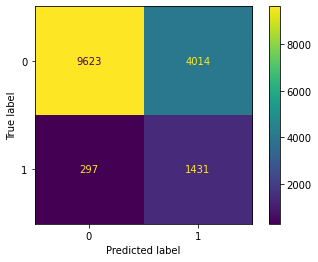

In [41]:
#evaluating the model
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,ConfusionMatrixDisplay
conf_matrix=confusion_matrix(y_test,y_pred)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
conf_matrix

<div>
<h3>True positives</h3>
<p>
The model correctly predicted 1431 instances of arrests made as YES ie an arrest was made.
</p>
<h3>True negative</h3>
<p>
The models correctly predicted 9623 instances that did not lead to arrest as NO ie no arrest was made when in reality no arrest was made.
</p>
<h3>False Negative</h3>
<p>
The model misclassied 297 instances ie did not lead to an arrest when they actually led to an arrest.
</p>
<h3>False positive</h3>
 <p>
4014 instances were misclassified as led to an arrest when they actually didnt.
</p>
</div>


In [44]:
log_classification_report=classification_report(y_test, y_pred)
print(log_classification_report)

              precision    recall  f1-score   support

           0       0.97      0.71      0.82     13637
           1       0.26      0.83      0.40      1728

    accuracy                           0.72     15365
   macro avg       0.62      0.77      0.61     15365
weighted avg       0.89      0.72      0.77     15365



The logistic regression model achieved an overall accuracy of 72%.Despite oversampling the the minority class the model still performs poorely at predicting the minority class.

<div>
<h3>2.1.0 Model evaluation</h3>
<h3>Precision (97%,26%):</h3>

The model is very good at correctly identifying negative samples (class 0).
                
only 26% of predicted positives are actually positive.This indicates many false positives.
            

<h3>Recall(71%,83%):</h3>

The model misses about 29% of actual negative samples, indicating some room for improvement in correctly identifying all negative cases.
       
The model successfully identifies a high proportion of actual positives, capturing most positive samples.


<h3>f1 score(82%,40%):</h3>

This reflects a balance between precision and recall for class 0 and indicates solid performance.
         
The F1-score is relatively low, showing poor balance between precision and recall for the minority class.
</div>

### 2.1.1 Conclusion
The model performs well for the majority class but struggles with the minority class.This necessitates a need for model improvement.

### 2.1.2 Recommenddation
Build a decision tree classifier to improve the performance of the model.

## 2.2 Building  a baseline decision tree classifier model
A Decision Tree Classifier is a type of machine learning algorithm used for classification and regression tasks. It models data by creating a tree-like structure where each internal node represents a decision (based on a feature), each branch represents an outcome of that decision, and each leaf node represents a class label or a predicted outcome.

<h3>Use cases</h3>

Decision tree can  be used for other classifications such as Customer Churn Prediction,Credit Scoring (Loan Approval),Medical Diagnosis,Fraud Detection and Sales and Marketing Campaign Effectiveness.

<h3>Advatages</h3>

1.Works well with frequency encoded data such as the above dataset.

2.Easy visualization and interpretability as it mimics human decision making process.

In [47]:
#creating a decision tree classifier 
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(criterion='entropy',random_state=42)

In [48]:
#building a model.Fitting the training resampled data
model_clf=clf.fit(X_resampled,y_resampled)

In [49]:
#predicting y based on the x_test
y_pred=model_clf.predict(X_test)

In [50]:
clf_conf_matrix=confusion_matrix(y_test,y_pred)
clf_conf_matrix

array([[12707,   930],
       [  799,   929]])

In [197]:
test_class_report=classification_report(y_test,y_pred)
print(test_class_report)

              precision    recall  f1-score   support

           0       0.94      0.93      0.94     13637
           1       0.50      0.54      0.52      1728

    accuracy                           0.89     15365
   macro avg       0.72      0.73      0.73     15365
weighted avg       0.89      0.89      0.89     15365



The model's overall accuracy  improved from 72% for the logistic regression model to 89% for the decision tree classifier.The recall,precision and f1 score have also improved indicating that the decision tree model predicts the minority class better than the logistic regression model.Next step is to look at the performance of the model on the training data.   

In [51]:
#model performance on the train dataset
y_train_pred=model_clf.predict(X_resampled)
clf_train_conf_matrix=confusion_matrix(y_train_pred,y_resampled)
clf_train_conf_matrix
#class_report=classification_report(y_train_pred,y_train)
#print(class_report)

array([[41060,    96],
       [    2, 40966]])

The model performs exceptionally well on the training data with only 2 instances of false negative ie did not result into an arrest when the incident resulted into an arrest.The model falsely predicted 96 cases as false positive ie led to an arrest when they actually did not.

In [52]:
desion_classification_report=classification_report(y_train_pred,y_resampled)
print(desion_classification_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     41156
           1       1.00      1.00      1.00     40968

    accuracy                           1.00     82124
   macro avg       1.00      1.00      1.00     82124
weighted avg       1.00      1.00      1.00     82124



The model's performance on the training set with precision=recall=accuracy=f1score=100% is an indicator of overfitting.The model has memorized the data points rather than learning from them.Remedy to this is hypertuning the parameters to reduce overfitting.

### Visualization using ROC curve and AUC

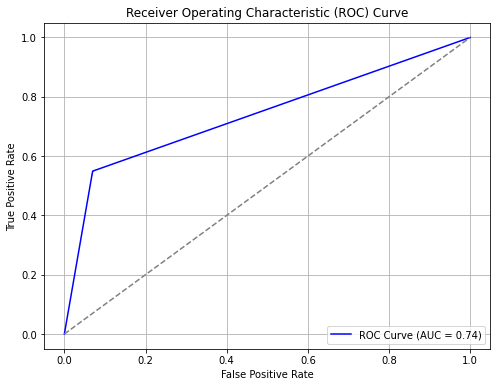

In [53]:
# Getting predicted probabilities for the positive class
y_pred_proba = model_clf.predict_proba(X_test)[:, 1]  # Probabilities for class 1

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Compute the Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()


The Area Under the Curve (AUC) value is 0.74, indicating that the model has moderate performance

### Hypertuning the parameters to solve the problem of overfitting

In [54]:
from sklearn.model_selection import GridSearchCV
# Define the model
clf = DecisionTreeClassifier(random_state=42)

# Define the hyperparameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],           # Function to measure the quality of a split
    'max_depth': [None, 10, 20, 30, 40, 50],    # Maximum depth of the tree
    'min_samples_split': [2, 10, 20],           # Minimum number of samples to split an internal node
    'min_samples_leaf': [1, 5, 10],             # Minimum number of samples at a leaf node
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_resampled, y_resampled)

# Best hyperparameters
print("Best parameters:", grid_search.best_params_)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}


GridSearchCV takes a bit too long because it exhaustively seaches through all the specified parameters.For a faster search,RandomizedSearchCV can also be applied. 

In [55]:
#creating another model filling in the parameters
clf_tuned=DecisionTreeClassifier(criterion='entropy',max_depth =20,min_samples_leaf=1,min_samples_split=2,random_state=42)

In [56]:
tuned_model=clf_tuned.fit(X_resampled,y_resampled)

In [57]:
y_pred1=tuned_model.predict(X_test)

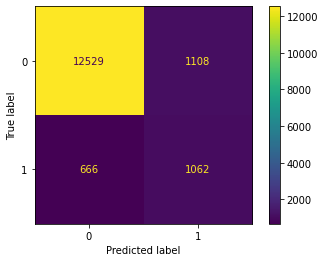

In [58]:
#evaluating the performance of the model with the tuned parameters
con_matrix=confusion_matrix(y_test,y_pred1)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred1)

Hypertuning the parameters has decreased the false negative,decreased the true negatives ,increased both the false positive and true positive.Has tuning improved the metrics?

In [59]:
tuned_class_report=classification_report(y_test,y_pred1)
print(tuned_class_report)

              precision    recall  f1-score   support

           0       0.95      0.92      0.93     13637
           1       0.49      0.61      0.54      1728

    accuracy                           0.88     15365
   macro avg       0.72      0.77      0.74     15365
weighted avg       0.90      0.88      0.89     15365



Hyper tuning slightly improved the f1 score thus prioritizing the minority class.The accuracy however decreased slightly from 89 to 88 precision has slightly improved from 89 to 90%.

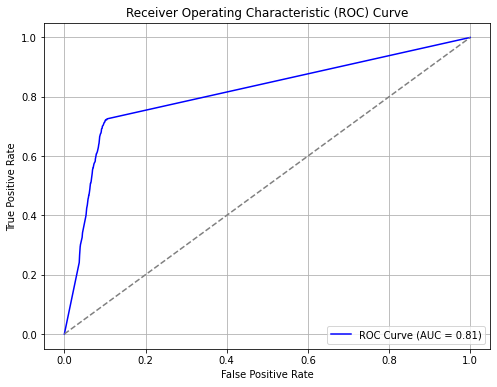

In [60]:
#ROC curvevisualization
y_pred_proba = tuned_model.predict_proba(X_test)[:, 1]  # Probabilities for class 1

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Compute the Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

The model demonstrates moderate performance and can be improved further.A random forest classifier can improve the performance of the model.

### 2.3 Building a random forest classifier.

In [68]:
from sklearn.ensemble import RandomForestClassifier
#creating an instance
random=RandomForestClassifier(max_depth =20,min_samples_leaf=1,min_samples_split=2)
rand_model=random.fit(X_resampled,y_resampled)
y_hat = rand_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_hat)
print(conf_matrix)


[[12403  1234]
 [  500  1228]]


In [69]:
report=classification_report(y_test, y_hat)
print(report) 

              precision    recall  f1-score   support

           0       0.96      0.91      0.93     13637
           1       0.50      0.71      0.59      1728

    accuracy                           0.89     15365
   macro avg       0.73      0.81      0.76     15365
weighted avg       0.91      0.89      0.90     15365



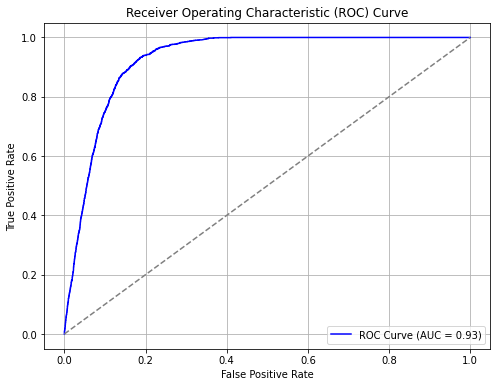

In [70]:
y_pred_proba = rand_model.predict_proba(X_test)[:, 1]  # Probabilities for class 1

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Compute the Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

The curve is close to the top-left corner, showing a high TPR and a low FPR, which signifies a good balance.AUC  of 0.93 indicates a strong predictive power of the model.

References

<sup>1</sup> Wikipedia contributors, *Automatic number-plate recognition*, Wikipedia, accessed December 6, 2024, <a href="https://en.wikipedia.org/wiki/Automatic_number-plate_recognition">https://en.wikipedia.org/wiki/Automatic_number-plate_recognition